In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [77]:
# the input catalog (central COSMOS, M>11.0)
graham_output_dir = dev_path + 'input_cats/'
cat_matched = Table.read(graham_output_dir+'cat_out_massive_08squdeg_nonir_il_nz_prior_nolimit.fits')

cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < 0.3) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < 0.3) )
cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < 0.3) ) 
cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < 0.3) )
cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < 0.3) )
cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < 0.3) )
cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < 0.3) )
flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)

cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < 0.3) )
cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < 0.3) )
cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < 0.3) )
cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < 0.3) )
flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)

cond_ch1 = ( (cat_matched['MAG_AUTO_CH1'] > 0.) & (cat_matched['MAG_AUTO_CH1'] < 50.) & (cat_matched['MAGERR_AUTO_CH1'] > 0.) & (cat_matched['MAGERR_AUTO_CH1'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2'] > 0.) & (cat_matched['MAG_AUTO_CH2'] < 50.) & (cat_matched['MAGERR_AUTO_CH2'] > 0.) & (cat_matched['MAGERR_AUTO_CH2'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

col_flag_optical = Column(name='flag_optical', data=flag_optical)
col_flag_nir = Column(name='flag_nir', data=flag_nir)
col_flag_irac = Column(name='flag_irac', data=flag_irac)

if 'flag_optical' in cat_matched.keys():
    cat_matched.remove_columns(['flag_optical','flag_nir','flag_irac'])
cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac])

cat_matched.write(graham_output_dir+'cat_out_massive_08squdeg_nonir_il_nz_prior_nolimit.fits', overwrite=True)

In [15]:
# the output catalogs (after photoz and mass runs)
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
# nz_prior = ''
cat_output_no_irac_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonirirac_il'+nz_prior+detect_limit+'_formass.fits'
cat_output_no_irac_mass_name = graham_output_dir+'cat_out'+name_tag+'_noirac_il'+nz_prior+detect_limit+'_formass.fits'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass.fits'
cat_output_full_mass_name = graham_output_dir+'cat_out'+name_tag+'_allphot_il'+nz_prior+detect_limit+'_formass.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']
flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']

In [24]:
# check massives (in optical+irac phot catalog)
print(cat_output_no_nir_mass_name)
cat_output_c20added = Table.read(cat_output_no_nir_mass_name.replace('.fits','c20added.fits'))

# selection condition
massive_cut=11.0
cond = (cat_output_c20added['MASS_MED_massrun']>massive_cut)  # my massive
massive_gals_selected = cat_output_c20added[cond]
massive_gals_selected.rename_columns(['RA_1','DEC_1','ID_1'],['RA','DEC','ID'])
massive_gals_selected.write('lp_massive_gal_check/lp_massive_gal_check.fits',overwrite=True)
print(len(massive_gals_selected))


/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits
3387


In [12]:
# re-fitted massive gals

cat_massive_224 = Table.read(graham_output_dir+'cat_out_massive_nonir_22.4_formass.fits')
cat_massive_232 = Table.read(graham_output_dir+'cat_out_massive_nonir_23.2_formass.fits')
cat_massive_nolimit = Table.read(graham_output_dir+'cat_out_massive_nonir_nolimit_formass.fits')

cat_massive_224 = cat_massive_224['RA','DEC','Z_ML','MASS_MED_massrun']
cat_massive_232 = cat_massive_232['Z_ML','MASS_MED_massrun']
cat_massive_nolimit = cat_massive_nolimit['Z_ML','MASS_MED_massrun']

cat_massive = hstack([cat_massive_224,cat_massive_232,cat_massive_nolimit],table_names=['224','232','nolimit'])
cat_massive.write('lp_massive_gal_check/lp_massive_gal_rerun.fits',overwrite=True)

In [25]:
cat_output_name = 'lp_massive_gal_check/lp_massive_gal_rerun.fits'
original_massive_name = 'lp_massive_gal_check/lp_massive_gal_check.fits'
combined_cat_name = cat_output_name.replace('.fits','refit_added.fits')
    
col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+original_massive_name+' values2="RA DEC" \
       in3=/Users/lejay/research/massive_gals/clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
# print(cmd)
os.system(cmd)

0

53
306
374
471


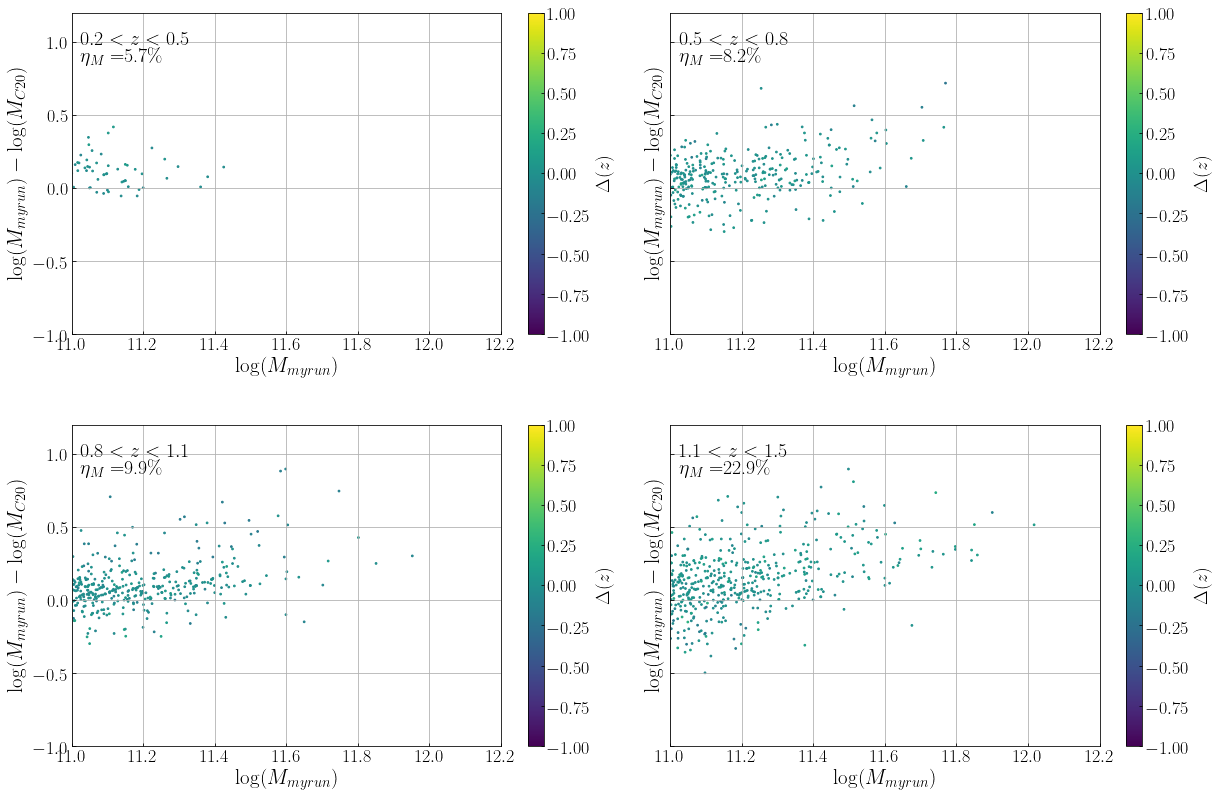

In [82]:
fig, axs = plt.subplots(2, 2, figsize = (18, 12), sharey=True)
cat_massive_combined = Table.read(cat_output_name.replace('.fits','refit_added.fits'))
cat_massive_combined = cat_massive_combined[cat_massive_combined['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq_show = 'all' # 'all' or 'split'


for i,z_min in enumerate(z_mins):
    row = i // 2; col = i % 2
    cat_z = cat_massive_combined[cat_massive_combined['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
    flag_photoz = cat_z['flag_photoz']
    
    cond_photoz = flag_photoz==1
    cond_filters = (flag_optical>3) & (flag_irac>1)
    cond_photoz_match = abs(cat_z['Z_ML'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    cond =  cond_filters & cond_photoz & cond_photoz_match
    cat_z = cat_z[cond]
    
    #data to plot
    x = np.array(cat_z['MASS_MED_massrun_nolimit'])
    y = np.array(cat_z['MASS_MED_massrun_nolimit'] - cat_z['lp_mass_med'])
    print(len(x))
    
    # plot
    dz = cat_z['Z_ML'] - cat_z['lp_zPDF']
    im = axs[row][col].scatter(x,y,s=3,c=dz,alpha=1,vmin=-1,vmax=1)
    axs[row][col].set_xlabel(r'$\log(M_{myrun})$',fontsize=21)
    axs[row][col].set_ylabel(r'$\log(M_{myrun}) - \log(M_{C20})$',fontsize=21)
    axs[row][col].set_xlim([11.0,12.2])
    axs[row][col].set_ylim([-1,1.2])
    axs[row][col].grid()
        
    # print out mass outlier fraction
    outlier_factor = 0.3
    num_outliers = len(cat_z[abs(cat_z['MASS_MED_massrun'] - cat_z['lp_mass_med'])>outlier_factor])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].annotate('$\eta_{M}=$'+str(round(num_outliers/len(cat_z)*100,1))+'\% ',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
     
    cbar = fig.colorbar(im, ax=axs[row][col])
    cbar.ax.set_ylabel('$\Delta(z)$',fontsize=19)
    
plt.tight_layout(pad=4, w_pad=2)


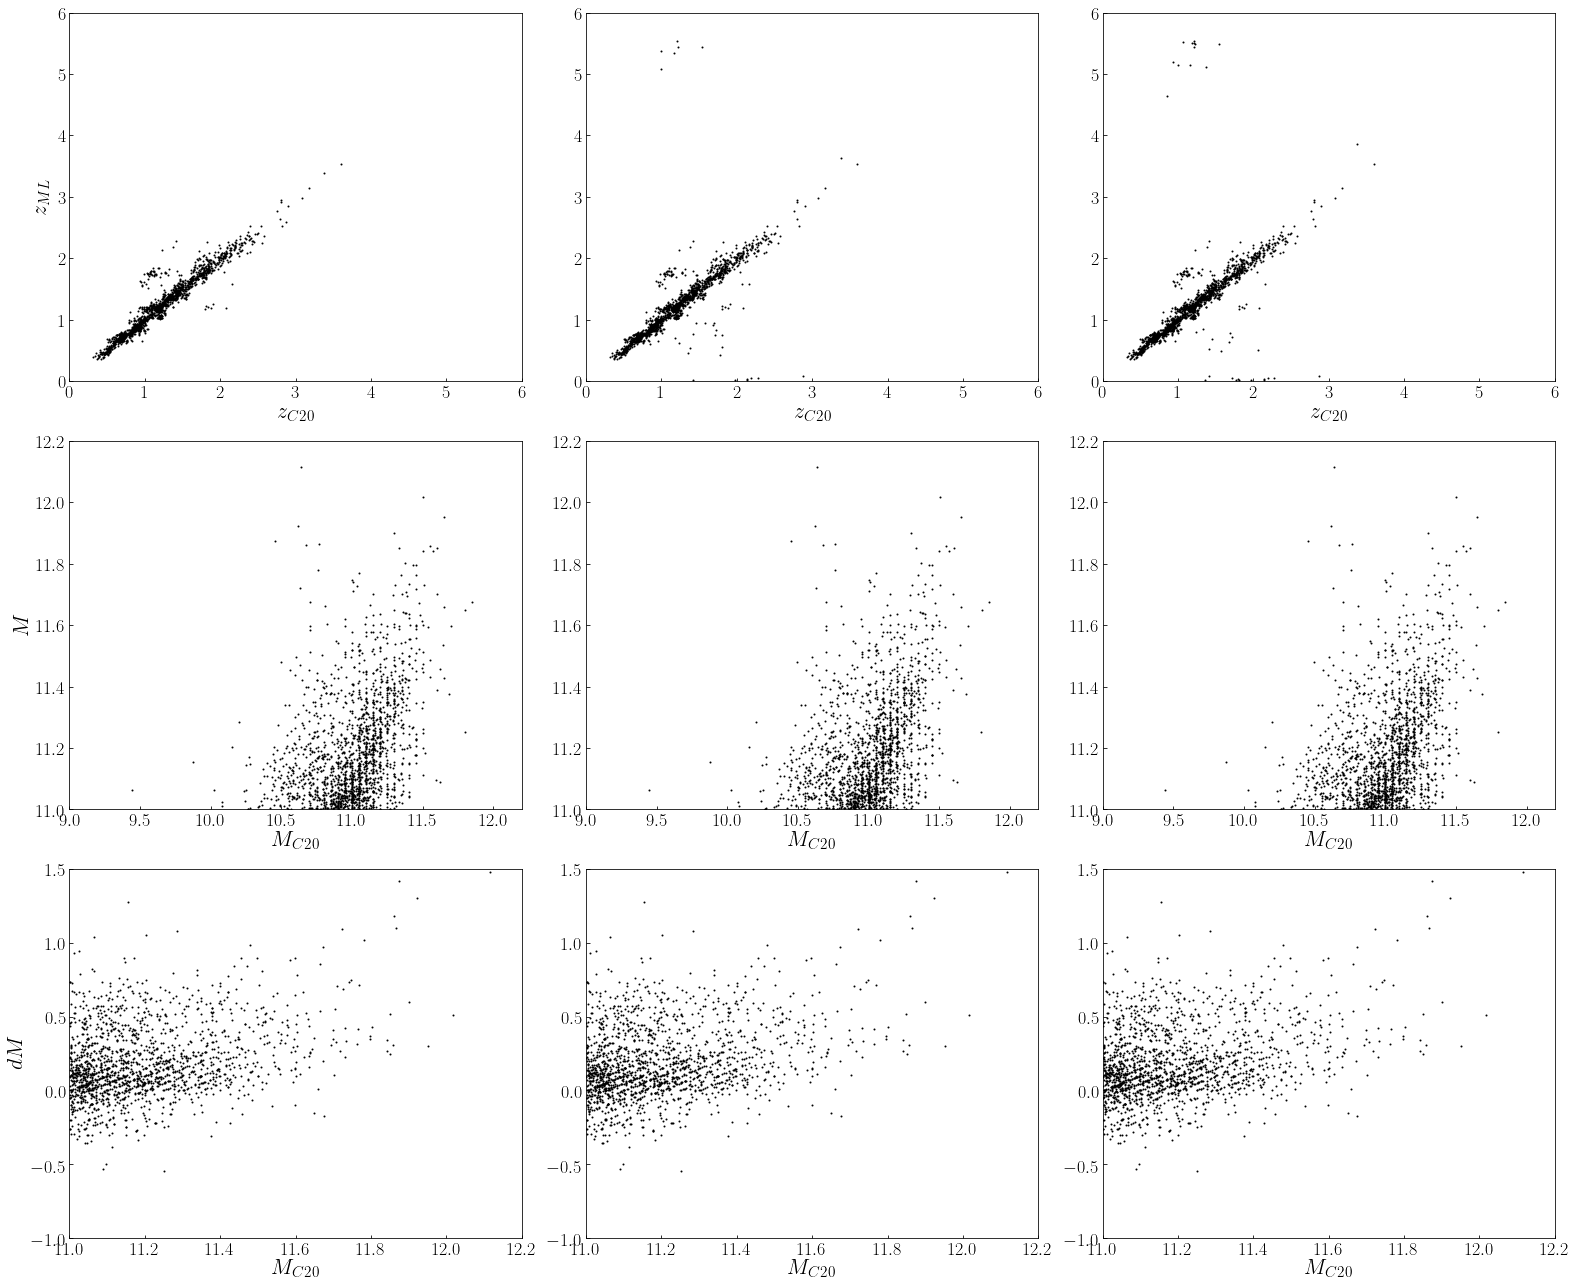

In [90]:
# something
cat_massive_combined = Table.read(cat_output_name.replace('.fits','refit_added.fits'))
# flags
flag_photoz = cat_massive_combined['flag_photoz']==1  # consistent photoz within C20 catalog
flag_optical = cat_massive_combined['flag_optical'] 
flag_irac = cat_massive_combined['flag_irac'] 
flag_nir = cat_massive_combined['flag_nir'] 

# selection condition
cond_filters = (flag_optical>=4) & (flag_irac>=1) & flag_photoz
cat_massive_combined = cat_massive_combined[cond_filters]

fig, axs = plt.subplots(3, 3, figsize = (22, 18))

# z-z plot
axs[0][0].scatter(cat_massive_combined['lp_zPDF'],cat_massive_combined['Z_ML_nolimit'],s=1,color='k')
axs[0][1].scatter(cat_massive_combined['lp_zPDF'],cat_massive_combined['Z_ML_224'],s=1,color='k')
axs[0][2].scatter(cat_massive_combined['lp_zPDF'],cat_massive_combined['Z_ML_232'],s=1,color='k')
axs[0][0].set_xlim([0,6])
axs[0][0].set_ylim([0,6])
axs[0][1].set_xlim([0,6])
axs[0][1].set_ylim([0,6])
axs[0][2].set_xlim([0,6])
axs[0][2].set_ylim([0,6])
axs[0][0].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][1].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][2].set_xlabel('$z_{C20}$',fontsize=22)
axs[0][0].set_ylabel('$z_{ML}$',fontsize=22)

# M-M plot
axs[1][0].scatter(cat_massive_combined['lp_mass_med'],cat_massive_combined['MASS_MED_massrun'],s=1,color='k')
axs[1][1].scatter(cat_massive_combined['lp_mass_med'],cat_massive_combined['MASS_MED_massrun_224'],s=1,color='k')
axs[1][2].scatter(cat_massive_combined['lp_mass_med'],cat_massive_combined['MASS_MED_massrun_232'],s=1,color='k')
axs[1][0].set_xlim([9,12.2])
axs[1][0].set_ylim([11,12.2])
axs[1][1].set_xlim([9,12.2])
axs[1][1].set_ylim([11,12.2])
axs[1][2].set_xlim([9,12.2])
axs[1][2].set_ylim([11,12.2])
axs[1][0].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][1].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][2].set_xlabel('$M_{C20}$',fontsize=22)
axs[1][0].set_ylabel('$M$',fontsize=22)

# dM-M plot
axs[2][0].scatter(cat_massive_combined['MASS_MED_massrun'],cat_massive_combined['MASS_MED_massrun']-cat_massive_combined['lp_mass_med'],s=1,color='k')
axs[2][1].scatter(cat_massive_combined['MASS_MED_massrun_224'],cat_massive_combined['MASS_MED_massrun_224']-cat_massive_combined['lp_mass_med'],s=1,color='k')
axs[2][2].scatter(cat_massive_combined['MASS_MED_massrun_232'],cat_massive_combined['MASS_MED_massrun_232']-cat_massive_combined['lp_mass_med'],s=1,color='k')
axs[2][0].set_xlim([11.0,12.2])
axs[2][0].set_ylim([-1,1.5])
axs[2][1].set_xlim([11.0,12.2])
axs[2][1].set_ylim([-1,1.5])
axs[2][2].set_xlim([11.0,12.2])
axs[2][2].set_ylim([-1,1.5])
axs[2][0].set_xlabel('$M_{C20}$',fontsize=22)
axs[2][1].set_xlabel('$M_{C20}$',fontsize=22)
axs[2][2].set_xlabel('$M_{C20}$',fontsize=22)
axs[2][0].set_ylabel('$dM$',fontsize=22)

plt.tight_layout()

Text(0, 0.5, '$z_{C20}$')

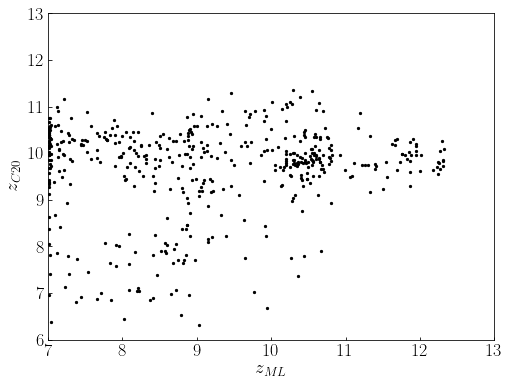

In [98]:
# compare new masses (for massive gals with no irac detection) to M_C20
fig, axs = plt.subplots(1, 1, figsize = (8, 6))

cat_massive_new = Table.read('lp_massive_gal_check/lp_massive_gal_check_c20added.fits')

plt.scatter(cat_massive_new['MASS_MED'],cat_massive_new['lp_mass_med'],s=5,color='k')
plt.xlim([7,13])
plt.ylim([6,13])
plt.xlabel('$z_{ML}$',fontsize=19)
plt.ylabel('$z_{C20}$',fontsize=19)

In [ ]:
for i,z_range in enumerate([(0.2,0.5),(0.5,0.8),(0.8,1.1),(1.1,1.5)]):
    row = i // 2; col = i % 2
    cat_name = cat_output_no_nir_mass_name
    cat_output_c20added = Table.read(cat_name.replace('.fits','c20added.fits'))
    cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
    cat_output_c20added = cat_output_c20added[cat_output_c20added['Z_ML']>z_range[0]]
    cat_output_c20added = cat_output_c20added[cat_output_c20added['Z_ML']<z_range[1]]
    cat_output_c20added = cat_output_c20added[abs(cat_output_c20added['Z_ML'] - cat_output_c20added['Z_BEST'])<0.05]
    print(cat_name.replace('.fits','c20added.fits'))
    
    select_ids = np.random.choice(np.arange(len(cat_output_c20added)), size=int(len(cat_output_c20added)/5), replace=False)
    cat_output_c20added = cat_output_c20added[select_ids]
    
    # conditions
    cond = np.ones(len(cat_output_c20added)).astype(bool)
    fig_title = 'All Galaxies ($i<26$)'
    cond = cond # & flag_photoz
    
    # plot
    x = cat_output_c20added[cond]['lp_mass_med']
    y = cat_output_c20added[cond]['MASS_MED_massrun'] - cat_output_c20added[cond]['lp_mass_med']
    im = axs[row][col].scatter(x,y,s=7,c=cat_output_c20added[cond]['flag_irac'],vmin=0,vmax=2,cmap='Paired',zorder=10)
    
    # histograms
    xmax = 12.9
    cat_z_sat_mass = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>9.5]
    axs[row][col].hist(cat_z_sat_mass['MASS_MED_massrun']-cat_z_sat_mass['lp_mass_med'],bins=50,range=(-2,2),orientation='horizontal',bottom=xmax, weights=-3/len(cat_z_sat_mass)*np.ones(len(cat_z_sat_mass)),color='r',alpha=0.3)
    cat_z_cen_mass = cat_output_c20added[cat_output_c20added['MASS_MED_massrun']>massive_cut]
    if len(cat_z_cen_mass)>0:
        axs[row][col].hist(cat_z_cen_mass['MASS_MED_massrun']-cat_z_cen_mass['lp_mass_med'],bins=30,range=(-2,2),orientation='horizontal',bottom=xmax, weights=-1.2/len(cat_z_cen_mass)*np.ones(len(cat_z_cen_mass)),color='b',alpha=0.3)
    
    axs[row][col].set_xlim([9,xmax])
    axs[row][col].set_ylim([-1,1])
    axs[row][col].set_xlabel(r'$\log(M_{C20})$',fontsize=19)
    axs[row][col].set_ylabel(r'$\log(M_{myrun})-\log(M_{C20})$',fontsize=19)
    axs[row][col].axvline(x=11.2,ymin=0,ymax=1,color='k',ls='--',alpha=0.5)
    axs[row][col].axhline(y=0,xmin=0,xmax=1,color='k',ls='--',alpha=0.5)
    axs[row][col].annotate('$'+str(z_range[0])+'<z<'+str(z_range[1])+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k',zorder=0)
    
    cbar = fig.colorbar(im, ax=axs[row][col])
    cbar.ax.set_ylabel('Flag IRAC',fontsize=19)

#### Visual Checks

In [ ]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from astropy.io import fits
import aplpy

In [44]:
def find_patch(ra, dec, field='COSMOS_deep'):
    patch_list = []
    cat_patches = Table.read('tract_patches/'+field+'_patches.fits')
    for patch in cat_patches:
        if ra < patch['corner0'][0] and ra > patch['corner1'][0] and dec < patch['corner2'][1] and dec > patch['corner1'][1]:
            patch_list.append([str(patch['tract']), str(patch['patch'])])

    return patch_list

In [57]:
# add tract and patch info

tract_list = []
patch_list = []
for gal in massive_gals_selected_z:
    tract,patch = find_patch(gal['RA'], gal['DEC'], field='COSMOS_deep')[0]
    tract_list.append(tract)
    patch_list.append(patch)

col_tract = Column(name='TRACT',data=tract_list)
col_patch = Column(name='PATCH',data=patch_list)
massive_gals_selected_z.add_columns([col_tract,col_patch])
massive_gals_selected_z.write('lp_massive_gal_check/lp_massive_gal_check_z.fits',overwrite=True)

In [58]:
# load v9 catalog
cat_v9 = Table.read('/Volumes/LejaySSD/v9_cats/COSMOS_deep_v9.fits')
cat_v9 = cat_v9[cat_v9['inside_u'] == True]
cat_v9 = cat_v9[cat_v9['MASK'] == 0]  # unmasked
cat_v9 = cat_v9[cat_v9['OBJ_TYPE'] == 0]  # galaxies
cat_v9 = cat_v9['ID','RA','DEC']

4414618 0.4382 0.437 11.3099 11.29963


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4448244 0.3062 0.2632 11.5962 11.39449


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4579090 0.3883 0.3494 11.234 10.80592


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4584888 0.4943 0.3607 11.6503 11.39996


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

4587586 0.3667 0.2296 11.223 10.40315


/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6/site-packages/aplpy/normalize.py:92: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(value):
/Users/lejay/anaconda3/lib/python3.6

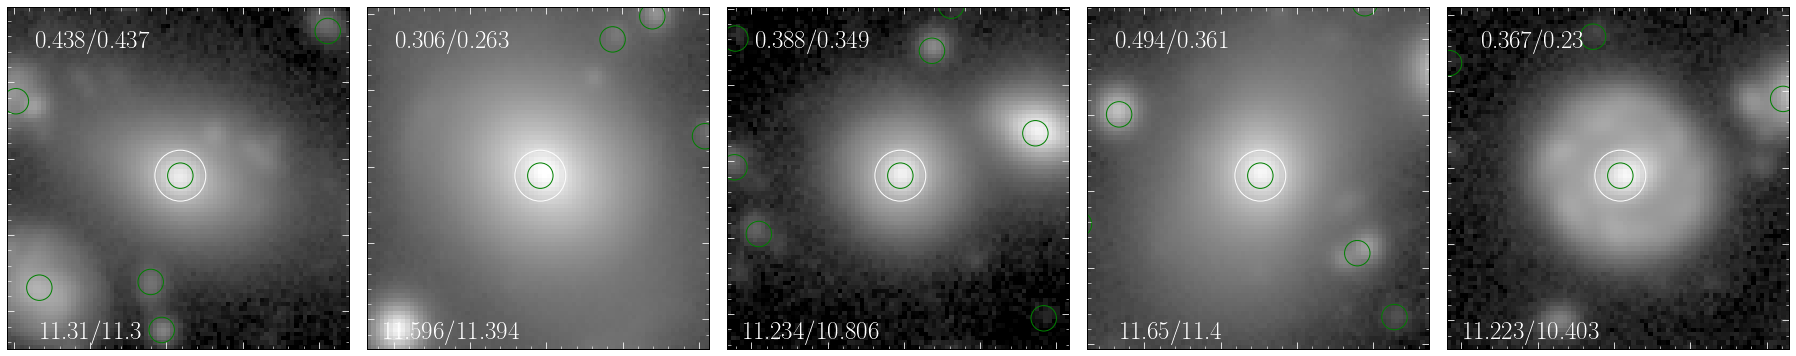

In [61]:
fig = plt.figure(figsize=(25, 5))

for i, gal in enumerate(massive_gals_selected_z[5:10]):
    row = i // 5
    col = i % 5
    
    print(gal['ID'],gal['Z_ML'],gal['lp_zPDF'],gal['MASS_MED_massrun'],gal['lp_mass_med'])
    
    # plot 
    gc = aplpy.FITSFigure('lp_massive_gal_check/cutout_'+str(gal['ID'])+'.fits',figure=fig,subplot=[0.1+col*0.2, 0.1+row*0.1, 0.19, 0.95])
    
    # cut cat_v9
    ra_cen,dec_cen = gal['RA'],gal['DEC']
    cat_v9_cut = cat_v9[abs(cat_v9['RA']-ra_cen)<10./3600]
    cat_v9_cut = cat_v9_cut[abs(cat_v9_cut['DEC']-dec_cen)<10./3600]
    gc.show_circles(cat_v9_cut['RA'],cat_v9_cut['DEC'],radius=0.5/3600.,color='green')
    
    gc.show_grayscale(stretch='log',vmin=2,vmax=5e3)
    gc.hide_yaxis_label()
    gc.hide_ytick_labels()
    gc.hide_xaxis_label()
    gc.hide_xtick_labels()
    
    gc.add_label(0.25,0.9,str(round(gal['Z_ML'],3))+'/'+str(round(gal['lp_zPDF'],3)),relative=True,fontsize=25,color='w')
    gc.add_label(0.25,0.05,str(round(gal['MASS_MED_massrun'],3))+'/'+str(round(gal['lp_mass_med'],3)),relative=True,fontsize=25,color='w')
    
    gc.show_circles(gal['RA'],gal['DEC'],radius=1/3600.,color='white')